For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

In [3]:
# Importing modules
import pandas as pd
import os

# Read data into papers
papers = pd.read_csv('papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

In [4]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
5321,2015,Regularization Path of Cross-Validation Error ...,Careful tuning of a regularization parameter i...,Regularization Path of\nCross-Validation Error...
800,1999,Optimal Sizes of Dendritic and Axonal Arbors,Abstract Missing,Optimal sizes of dendritic and axonal arbors\n...
200,1996,Balancing Between Bagging and Bumping,Abstract Missing,Balancing between bagging and bumping\n\nTom H...
3811,2011,Multiclass Boosting: Theory and Algorithms,The problem of multiclass boosting is conside...,Multiclass Boosting: Theory and Algorithms\n\n...
2154,2005,Goal-Based Imitation as Probabilistic Inferenc...,Abstract Missing,Goal-Based Imitation as Probabilistic Inferenc...


Remove punctuation/lower casing  
Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [5]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

5321    regularization path of\ncross-validation error...
800     optimal sizes of dendritic and axonal arbors\n...
200     balancing between bagging and bumping\n\ntom h...
3811    multiclass boosting: theory and algorithms\n\n...
2154    goal-based imitation as probabilistic inferenc...
Name: paper_text_processed, dtype: object

Step 3: Exploratory Analysis
To verify whether the preprocessing, we’ll make a simple word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

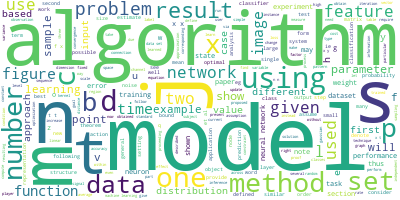

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

Step 4: Prepare text for LDA analysis
Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [7]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /Users/Ben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['regularization', 'path', 'cross', 'validation', 'error', 'lower', 'bounds', 'atsushi', 'shibagaki', 'yoshiki', 'suzuki', 'masayuki', 'karasuyama', 'ichiro', 'takeuchi', 'nagoya', 'institute', 'technology', 'nagoya', 'japan', 'gmailcom', 'nitechacjp', 'abstract', 'careful', 'tuning', 'regularization', 'parameter', 'indispensable', 'many', 'machine']


In [8]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 4), (15, 2), (16, 2), (17, 20), (18, 1), (19, 8), (20, 1), (21, 2), (22, 1), (23, 7), (24, 1), (25, 4), (26, 1), (27, 1), (28, 2), (29, 1)]


Step 5: LDA model tranining ¶
To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [36]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=10, 
                                      chunksize=100,
                                      passes=50, 
                                      iterations=100)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.008*"model" + 0.008*"features" + 0.005*"models" + 0.004*"feature" + '
  '0.004*"function" + 0.004*"data" + 0.004*"time" + 0.004*"one" + '
  '0.004*"learning" + 0.004*"distribution"'),
 (1,
  '0.007*"data" + 0.004*"matrix" + 0.004*"using" + 0.004*"kernel" + '
  '0.004*"information" + 0.004*"function" + 0.004*"based" + 0.004*"two" + '
  '0.004*"learning" + 0.003*"methods"'),
 (2,
  '0.007*"data" + 0.007*"learning" + 0.006*"network" + 0.005*"model" + '
  '0.005*"image" + 0.005*"training" + 0.005*"neural" + 0.004*"set" + '
  '0.004*"using" + 0.004*"number"'),
 (3,
  '0.006*"algorithm" + 0.005*"learning" + 0.004*"set" + 0.004*"using" + '
  '0.004*"log" + 0.004*"one" + 0.004*"model" + 0.004*"regret" + 0.004*"also" + '
  '0.004*"xt"'),
 (4,
  '0.007*"time" + 0.007*"model" + 0.006*"set" + 0.005*"data" + '
  '0.005*"learning" + 0.005*"one" + 0.004*"number" + 0.004*"algorithm" + '
  '0.004*"figure" + 0.004*"state"')]


Step 6: Analyzing our LDA model 
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

Better understanding and interpreting individual topics, and
Better understanding the relationships between the topics.
For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [33]:
# import pyLDAvis.gensim
import pickle 
import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# from pyLDAvis import gensim
# import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/results/ldavis_prepared_'+str(num_topics))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)


pyLDAvis.save_html(LDAvis_prepared, str(num_topics) +'.html')

LDAvis_prepared

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.006231  0.000891       1        1  28.605183
0      0.002363  0.003326       2        1  23.672944
1     -0.006346  0.003606       3        1  16.512315
2     -0.001007 -0.000970       4        1  16.260189
4     -0.001240 -0.006852       5        1  14.949369, topic_info=              Term         Freq        Total Category  logprob  loglift
17       algorithm   865.000000   865.000000  Default  30.0000  30.0000
1409         model  1096.000000  1096.000000  Default  29.0000  29.0000
698            two   679.000000   679.000000  Default  28.0000  28.0000
140           data  1317.000000  1317.000000  Default  27.0000  27.0000
224        feature   417.000000   417.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
707          using   104.992047   929.787575   Topic5  -5.8328  -0.2806
1308  distribution    80.779717   593.720713   Topic5  -6.0949  -0.0942
406        methods    74.377096   487.829277   Topic5  -6.1775   0.0197
405         method    74.260431   499.000763   Topic5  -6.1791  -0.0045
23            also    76.603116   647.699803   Topic5  -6.1480  -0.2343

[446 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1576       1  0.273121  accuracy
1576       2  0.308526  accuracy
1576       3  0.166907  accuracy
1576       4  0.156792  accuracy
1576       5  0.101156  accuracy
...      ...       ...       ...
14867      1  0.185763      ztrw
14867      2  0.417966      ztrw
14867      3  0.092881      ztrw
14867      4  0.185763      ztrw
14867      5  0.092881      ztrw

[1378 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5])

In [37]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'doc_term_matrix' is not defined